## Compose

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

from sim.netrual import Component, NLT_reserve, NLT_components, NLT_accounts, NLT_REWARD  # noqa
from sim.data import get_batch_price, get_price, read_csv, format_ts as t
import pandas as pd
target = ['EOS', 'MANA', 'OMG', 'VEN', 'BNB', 'IOTA', 'ETH', 'BAT']
market_prices = get_batch_price(target)
m = market_prices.dropna()


In [2]:
# get_price('EOS')
m

,EOS,timestamp,MANA,OMG,VEN,BNB,IOTA,ETH,BAT
0,1.583040,1.502942e+09,0.016162,13.695406,0.165545,1.337833,0.301110,301.13,0.159207
1,1.570162,1.502943e+09,0.018768,13.124210,0.278916,1.315363,0.601720,298.00,0.162557
2,1.568672,1.502943e+09,0.018642,13.423960,0.267273,1.321293,7.532500,298.00,0.156335
3,1.579582,1.502943e+09,0.017574,13.332000,0.267614,1.332585,0.602823,299.05,0.144399
4,1.582127,1.502944e+09,0.017585,13.337114,0.254227,1.337267,1.109667,300.10,0.145095
5,1.578085,1.502944e+09,0.017106,13.014985,0.263869,1.326687,0.606531,299.39,0.153978
6,1.578085,1.502944e+09,0.017151,13.014077,0.263878,1.332956,0.840728,299.39,0.153782
7,1.578892,1.502944e+09,0.016509,12.711720,0.254201,1.341471,0.840728,299.60,0.153493
8,1.578892,1.502945e+09,0.016587,12.726000,0.249340,1.357649,0.779688,299.60,0.152484
9,1.582155,1.502945e+09,0.016481,12.746160,0.247248,1.366627,0.776776,300.79,0.146809


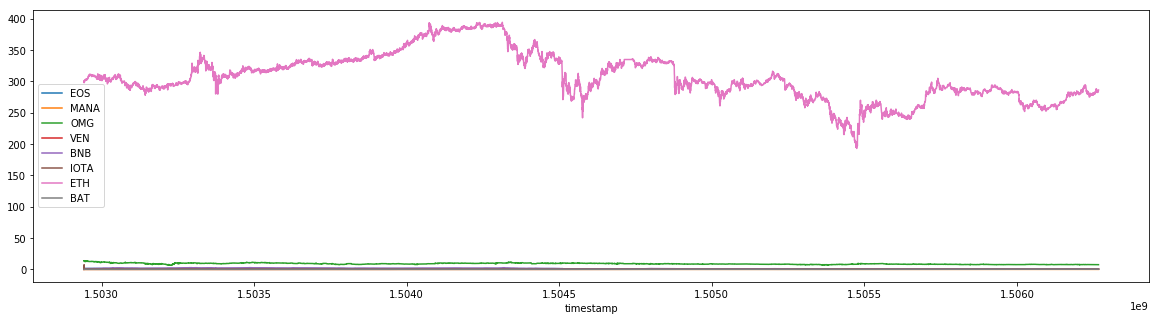

In [3]:
m.plot(x='timestamp', figsize=(20, 5))

In [4]:
tokens = [t for t in market_prices.columns if t != 'timestamp']
[Component(t) for t in tokens] 

[0.0 EOS => 0 NTL,
 0.0 MANA => 0 NTL,
 0.0 OMG => 0 NTL,
 0.0 VEN => 0 NTL,
 0.0 BNB => 0 NTL,
 0.0 IOTA => 0 NTL,
 0.0 ETH => 0 NTL,
 0.0 BAT => 0 NTL]

### Warmup with rational auction on fixed price

In [5]:
def rational_warmup(timestamp, market_price, sender, inital_price):
    for c in NLT_components.values():
        res = c(timestamp).auction(sender, (float(inital_price) / float(market_price[c.token])) * NLT_REWARD)
        print(res)

In [6]:
def warmup(m, p=15):
    mp = m.T[0].drop('timestamp')
    start_time = t(m.T[0]['timestamp']) - Component.auction_window - 1
    sender = 'satoshi'
    inital_price = float(p)  # 15 USD
    rational_warmup(start_time, mp, sender, inital_price)
    [c(m.T[0].timestamp) for c in NLT_components.values()]

\begin{gather*}
\mathbb{P}_{auction_t} = \frac{\mathbb{P}_{target}}{\mathbb{P}_{market}} \times 1000 \\
t = Time_{current} - Time_{window}
\end{gather*}

### Price via highest components $P_h$.

\begin{gather*}
\frac{Highest(Price_{components}) \times min_{bid}(Highest(Price_{components}))}{1000} \ for\ each\ components
\end{gather*}

### Price via average auction bid $P_a$.

\begin{gather*}
\frac{\sum{component_{highest\ bid}\times component_{price}}}{NLT_{amount\ per\ round}}
\end{gather*}




In [7]:
from sim.utils import nlt_price as p_h,  nlt_fm_price as p_a

In [8]:
from sim.utils import determin_auction_quantity, determin_redeem_quantity, get_worth_to_redeem
from sim.utils import redeem_strategy as redeem, auction_strategy as auction

In [9]:
def simulator(m, a_t, r_t, s_r):
    ret = []
    for i, data in m.iterrows():
        current = i
        print("==" * 10)
        print('round %s' % i)
        if i > s_r:
            plan_to_redeem = determin_redeem_quantity(data.drop('timestamp'), p_a, threshold=r_t)
            print('plan to redeem %s' % plan_to_redeem)
            redeem(plan_to_redeem, 'satoshi', data.timestamp)
        plan_to_auction = determin_auction_quantity(data.drop('timestamp'), p_a, threshold=a_t)
        auction(plan_to_auction, 'satoshi', data.timestamp)
        print('plan to auction %s' % plan_to_auction)

        ret.append(dict({
            'timestamp': data.timestamp,
            'price': p_a(data),
        }, **NLT_reserve))
    return pd.DataFrame(ret)


In [10]:

warmup(m, 15)

True
True
True
True
True
True
True
True
EOS:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
MANA:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
OMG:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
VEN:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
BNB:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
IOTA:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
ETH:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
BAT:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi


In [11]:
p_a(m.T[0]) # p_a

15.0

In [12]:
p_a(m.T[1]) # p_a

18.35318626294315

In [13]:
NLT_components

{'BAT': 94217.14035904269 BAT => 8000 NTL,
 'BNB': 11212.159558816793 BNB => 8000 NTL,
 'EOS': 9475.43720630606 EOS => 8000 NTL,
 'ETH': 49.812373393550956 ETH => 8000 NTL,
 'IOTA': 49815.68197668625 IOTA => 8000 NTL,
 'MANA': 928079.9881205761 MANA => 8000 NTL,
 'OMG': 1095.2577900593658 OMG => 8000 NTL,
 'VEN': 90609.58504434436 VEN => 8000 NTL}

In [14]:
m.T[1].drop('timestamp')

EOS       1.570162
MANA      0.018768
OMG      13.124210
VEN       0.278916
BNB       1.315363
IOTA      0.601720
ETH     298.000000
BAT       0.162557
Name: 1, dtype: float64

In [15]:
from sim.utils import get_redeem_price

In [16]:
get_redeem_price(m.T[1].drop('timestamp'))

{'BAT': 94.21714035904269,
 'BNB': 11.212159558816793,
 'EOS': 9.47543720630606,
 'ETH': 0.049812373393550956,
 'IOTA': 49.81568197668626,
 'MANA': 928.0799881205761,
 'OMG': 1.0952577900593659,
 'VEN': 90.60958504434436}

In [17]:
get_worth_to_redeem(m.T[1].drop('timestamp'), p_a)

{'IOTA': {'delta': 11621.905896068503,
  'min_bid': 49815.68197668625,
  'price': 0.60172},
 'VEN': {'delta': 6919.2459610872465,
  'min_bid': 90609.58504434436,
  'price': 0.2789156601}}

In [18]:
i = 1
np = p_a(m.T[i]) # p_a
q = 1000
{
    (NLT_components[token].get_redeem_price(q) * t_price * q)/ (np * (q + NLT_REWARD)) 
    for token, t_price in m.T[i].drop('timestamp').items()
}

{0.39160485468404543,
 0.40178474449069534,
 0.40440082333959154,
 0.4053239372600928,
 0.4172483815438847,
 0.4745164695304326,
 0.6885025810220721,
 0.816618208129186}

In [19]:
determin_redeem_quantity(m.T[1].drop('timestamp'), p_a)

{'VEN': 1000}

In [20]:
res = simulator(m, 0.01, 0.01, 0)

round 0
plan to auction {}
round 1
plan to redeem {'VEN': 1000}
plan to auction {'EOS': 11059.191697555032, 'MANA': 925252.9928917912, 'OMG': 1323.1060783829255, 'VEN': 62257.96912224508, 'BNB': 13201.467398830864, 'ETH': 58.270881054417465, 'BAT': 106822.22967802349}
round 2


ZeroDivisionError: float division by zero

In [ ]:
res.plot(y='price', x='timestamp', title="Price of NTL", figsize=(20, 10))

In [ ]:
res.drop(columns=['price']).plot(x='timestamp', figsize=(20, 10))

In [ ]:
pd.merge(m,
         pd.DataFrame(dict(NTL=res['price'], timestamp=res['timestamp'])),
         on='timestamp').drop(columns=['ETH']).plot(x='timestamp', title="Price Changes", figsize=(20, 10))

In [21]:
m.describe()

,EOS,timestamp,MANA,OMG,VEN,BNB,IOTA,ETH,BAT
count,11022.000000,1.102200e+04,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000
mean,1.012053,1.504604e+09,0.065702,9.082596,0.339573,1.521508,0.459192,307.204804,0.199970
std,0.334062,9.635453e+05,0.037275,1.075108,0.134563,0.709074,0.096970,37.771487,0.063545
min,0.482895,1.502942e+09,0.013272,6.526780,0.165545,0.503544,0.301110,193.100000,0.128794
25%,0.679737,1.503767e+09,0.017794,8.205073,0.243386,0.855845,0.408065,283.010000,0.160320
50%,0.956240,1.504592e+09,0.078798,8.915736,0.261581,1.250860,0.448055,301.225000,0.175064
75%,1.338159,1.505443e+09,0.097047,9.852690,0.466032,2.201847,0.497293,331.245000,0.217466
max,1.583040,1.506267e+09,0.140380,13.793944,0.883354,2.956131,7.532500,394.320000,0.439605
